In [1]:
import sys
print(sys.executable)

C:\Users\Abhishek\anaconda3\python.exe


In [2]:
!pip install pyspark

In [3]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set environment variables for better Spark connection
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

# Create a Spark session with more configuration options
spark = SparkSession.builder \
    .appName("IoT Anomaly Detection") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.cores.max", "4") \
    .config("spark.sql.shuffle.partitions", "100") \
    .config("spark.default.parallelism", "100") \
    .config("spark.driver.maxResultSize", "2g") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to reduce output verbosity
spark.sparkContext.setLogLevel("ERROR")

# Function to check if Spark session is active
def check_spark_connection():
    try:
        spark.sql("SELECT 1").show()
        print("Spark session is active and connected.")
    except Exception as e:
        print(f"Error connecting to Spark: {str(e)}")

# Check the Spark connection
check_spark_connection()

print("Spark session created successfully!")

+---+
|  1|
+---+
|  1|
+---+

Spark session is active and connected.
Spark session created successfully!


In [4]:
import os

def find_conn_log_files(root_dir):
    conn_log_files = []
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename == 'conn.log.labeled':
                conn_log_files.append(os.path.join(dirpath, filename))
    return conn_log_files

# Path to your dataset directory
dataset_dir = "../data/iot23_dataset"

# Find all conn.log.labeled files
conn_log_files = find_conn_log_files(dataset_dir)

print(f"Number of conn.log.labeled files found: {len(conn_log_files)}")

# Load all files into a single DataFrame
df = spark.read.csv(conn_log_files, header=True, inferSchema=True, sep="\t")

# Display the first few rows and schema
print("Dataset sample:")
df.show(5)
print("\nDataset schema:")
df.printSchema()

# Display the number of rows
print(f"\nTotal number of rows: {df.count()}")

Number of conn.log.labeled files found: 23
Dataset sample:
+---------------+
|#separator \x09|
+---------------+
| #set_separator|
|   #empty_field|
|   #unset_field|
|          #path|
|          #open|
+---------------+
only showing top 5 rows


Dataset schema:
root
 |-- #separator \x09: string (nullable = true)


Total number of rows: 325310130


In [5]:
from pyspark.sql.types import StructType, StructField, StringType, LongType, DoubleType

# Define the schema based on the Zeek conn.log format
schema = StructType([
    StructField("ts", StringType(), True),
    StructField("uid", StringType(), True),
    StructField("id.orig_h", StringType(), True),
    StructField("id.orig_p", LongType(), True),
    StructField("id.resp_h", StringType(), True),
    StructField("id.resp_p", LongType(), True),
    StructField("proto", StringType(), True),
    StructField("service", StringType(), True),
    StructField("duration", DoubleType(), True),
    StructField("orig_bytes", LongType(), True),
    StructField("resp_bytes", LongType(), True),
    StructField("conn_state", StringType(), True),
    StructField("local_orig", StringType(), True),
    StructField("local_resp", StringType(), True),
    StructField("missed_bytes", LongType(), True),
    StructField("history", StringType(), True),
    StructField("orig_pkts", LongType(), True),
    StructField("orig_ip_bytes", LongType(), True),
    StructField("resp_pkts", LongType(), True),
    StructField("resp_ip_bytes", LongType(), True),
    StructField("label", StringType(), True),
    StructField("detailed-label", StringType(), True)
])

# Load the data with the defined schema, skipping header lines
df = spark.read.csv(conn_log_files, sep="\t", schema=schema, comment="#")

# Display the first few rows and schema
print("Dataset sample:")
df.show(5)
print("\nDataset schema:")
df.printSchema()

# Display the number of rows
print(f"\nTotal number of rows: {df.count()}")

Dataset sample:
+-----------------+------------------+---------------+---------+---------------+---------+-----+-------+--------+----------+----------+----------+----------+----------+------------+-------+---------+-------------+---------+-------------+--------------------+--------------+
|               ts|               uid|      id.orig_h|id.orig_p|      id.resp_h|id.resp_p|proto|service|duration|orig_bytes|resp_bytes|conn_state|local_orig|local_resp|missed_bytes|history|orig_pkts|orig_ip_bytes|resp_pkts|resp_ip_bytes|               label|detailed-label|
+-----------------+------------------+---------------+---------+---------------+---------+-----+-------+--------+----------+----------+----------+----------+----------+------------+-------+---------+-------------+---------+-------------+--------------------+--------------+
|1525879831.015811|CUmrqr4svHuSXJy5z7|192.168.100.103|    51524| 65.127.233.163|       23|  tcp|      -|2.999051|         0|         0|        S0|         -|     

In [6]:
from pyspark.sql.functions import when, col

# Convert label to binary (0 for benign, 1 for malicious)
df = df.withColumn("is_malicious", when(col("label").contains("Malicio"), 1).otherwise(0))

# Select relevant features for the model
selected_features = [
    "duration", "orig_bytes", "resp_bytes", "missed_bytes",
    "orig_pkts", "orig_ip_bytes", "resp_pkts", "resp_ip_bytes",
    "is_malicious"
]

df_selected = df.select(selected_features)

# Handle null values
df_clean = df_selected.na.fill(0)

# Display basic statistics of the selected features
print("\nBasic statistics of selected features:")
df_clean.describe().show()

# Show the distribution of benign vs malicious samples
print("\nDistribution of benign vs malicious samples:")
df_clean.groupBy("is_malicious").count().show()


Basic statistics of selected features:
+-------+-------------------+--------------------+------------------+------------------+-----------------+------------------+--------------------+------------------+-------------------+
|summary|           duration|          orig_bytes|        resp_bytes|      missed_bytes|        orig_pkts|     orig_ip_bytes|           resp_pkts|     resp_ip_bytes|       is_malicious|
+-------+-------------------+--------------------+------------------+------------------+-----------------+------------------+--------------------+------------------+-------------------+
|  count|          325309946|           325309946|         325309946|         325309946|        325309946|         325309946|           325309946|         325309946|          325309946|
|   mean|0.16332870251918727|    6582886.59833383|107.05547942576585|12.470470527820874|2.269855269042404| 95.46882678773062|0.002423989827842...|1.3356742341963317| 0.9051344990232791|
| stddev| 13.202921333025962|4

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Step 1: Create a feature vector
feature_columns = ["duration", "orig_bytes", "resp_bytes", "missed_bytes", "orig_pkts", "orig_ip_bytes", "resp_pkts", "resp_ip_bytes"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_vectorized = assembler.transform(df_clean)


In [ ]:
# Step 2: Split the data into training and testing sets
train_data, test_data = df_vectorized.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Step 3: Train a Random Forest model
rf = RandomForestClassifier(labelCol="is_malicious", featuresCol="features", numTrees=10)
model = rf.fit(train_data)

In [ ]:
# Make predictions on the test set
predictions = model.transform(test_data)


In [ ]:
# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="is_malicious")
auc = evaluator.evaluate(predictions)

print(f"Area Under ROC: {auc}")

In [ ]:
# Show feature importances
feature_importances = model.featureImportances
for feature, importance in zip(feature_columns, feature_importances):
    print(f"{feature}: {importance}")

In [15]:
check_spark_connection()

+---+
|  1|
+---+
|  1|
+---+

Spark session is active and connected.


In [16]:
sample_ratio = 0.00001
df_sample = df_clean.sample(withReplacement=False, fraction=sample_ratio, seed=42)

print(f"\nSample dataset size: {df_sample.count()}")


Sample dataset size: 3207


In [17]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

sample_df=fd_sample

In [18]:
sample_df=df_sample
sample_df.head()

Row(duration=0.0, orig_bytes=0, resp_bytes=0, missed_bytes=0, orig_pkts=1, orig_ip_bytes=40, resp_pkts=0, resp_ip_bytes=0, is_malicious=0)

In [19]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

# Prepare features and target
feature_cols = ["duration", "orig_bytes", "resp_bytes", "missed_bytes", "orig_pkts", "orig_ip_bytes", "resp_pkts", "resp_ip_bytes"]

# Create feature vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
sample_df_vector = assembler.transform(sample_df).select("features", "is_malicious")

# Split the data
train_df, test_df = sample_df_vector.randomSplit([0.8, 0.2], seed=42)

# Check the split sizes
print(f"Train set size: {train_df.count()}")
print(f"Test set size: {test_df.count()}")

# Display a few rows from each set
print("\nTrain set sample:")
train_df.show(5, truncate=False)

print("\nTest set sample:")
test_df.show(5, truncate=False)

Train set size: 2563
Test set size: 644

Train set sample:
+--------------------------------+------------+
|features                        |is_malicious|
+--------------------------------+------------+
|(8,[0,4,5],[2.999046,3.0,180.0])|1           |
|(8,[4,5],[1.0,40.0])            |0           |
|(8,[4,5],[1.0,40.0])            |0           |
|(8,[4,5],[1.0,40.0])            |0           |
|(8,[4,5],[1.0,40.0])            |0           |
+--------------------------------+------------+
only showing top 5 rows


Test set sample:
+-----------------------------+------------+
|features                     |is_malicious|
+-----------------------------+------------+
|(8,[4,5],[1.0,40.0])         |0           |
|(8,[4,5],[1.0,60.0])         |1           |
|(8,[0,4,5],[2.0E-6,2.0,80.0])|1           |
|(8,[0,4,5],[6.0E-6,2.0,80.0])|1           |
|(8,[0,4,5],[6.0E-6,2.0,80.0])|1           |
+-----------------------------+------------+
only showing top 5 rows



In [20]:
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define the models
models = {
    "Random Forest": RandomForestClassifier(labelCol="is_malicious", featuresCol="features", seed=42),
    "Gradient Boosting": GBTClassifier(labelCol="is_malicious", featuresCol="features", seed=42),
    "SVM": LinearSVC(labelCol="is_malicious", featuresCol="features")
}

results = {}

for name, model in models.items():
    # Fit the model
    fitted_model = model.fit(train_df)
    
    # Make predictions
    predictions = fitted_model.transform(test_df)
    
    # Evaluate the model
    evaluator = MulticlassClassificationEvaluator(labelCol="is_malicious", predictionCol="prediction")
    
    results[name] = {
        "Accuracy": evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}),
        "Precision": evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"}),
        "Recall": evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"}),
        "F1-score": evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
    }

# Print results
for model, metrics in results.items():
    print(f"\n{model} Results:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")


Random Forest Results:
Accuracy: 0.9208
Precision: 0.9272
Recall: 0.9208
F1-score: 0.8932

Gradient Boosting Results:
Accuracy: 0.9301
Precision: 0.9278
Recall: 0.9301
F1-score: 0.9132

SVM Results:
Accuracy: 0.3339
Precision: 0.8697
Recall: 0.3339
F1-score: 0.4108


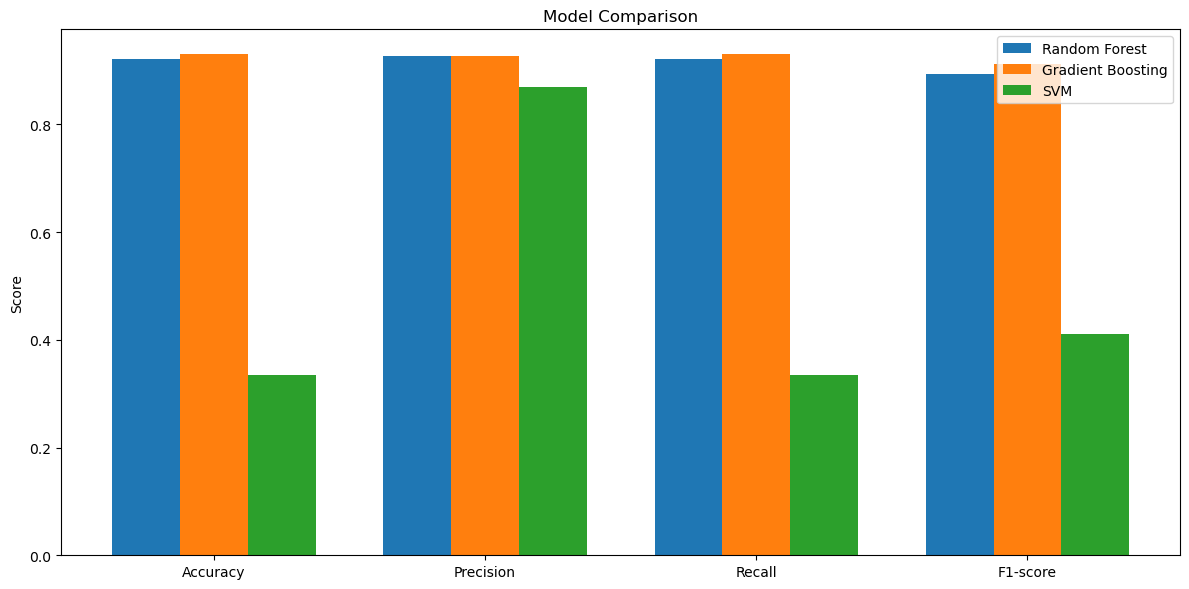

Best parameters:
numTrees: 100
maxDepth: <bound method _DecisionTreeParams.getMaxDepth of RandomForestClassificationModel: uid=RandomForestClassifier_31a414cb55d7, numTrees=100, numClasses=2, numFeatures=8>
minInstancesPerNode: <bound method _DecisionTreeParams.getMinInstancesPerNode of RandomForestClassificationModel: uid=RandomForestClassifier_31a414cb55d7, numTrees=100, numClasses=2, numFeatures=8>
Best cross-validation score: 0.9225

Final Model Performance:
Accuracy: 0.9317
Precision: 0.9325
Recall: 0.9317
F1-score: 0.9145


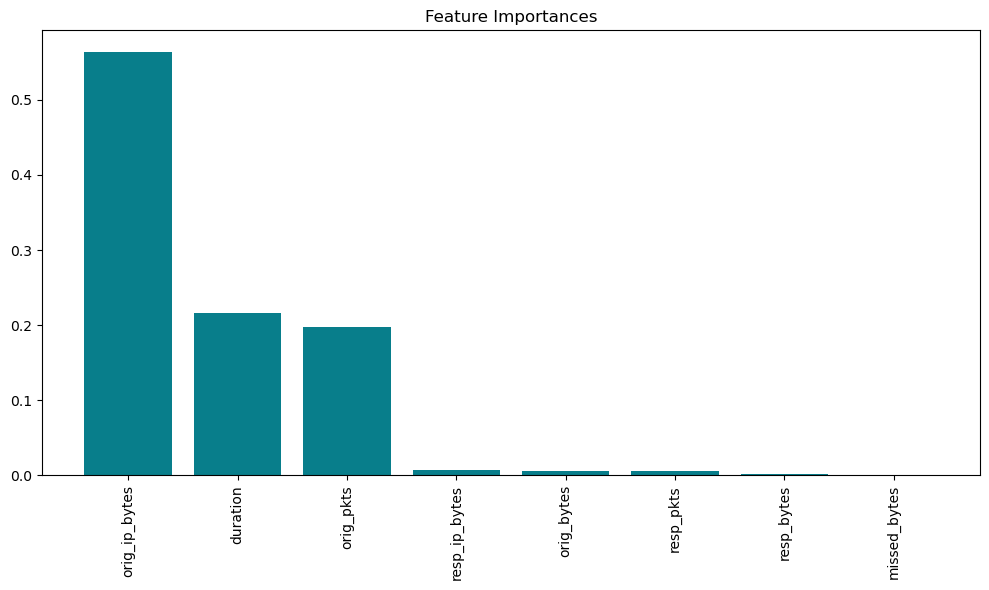

In [23]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt

# Visualization of current results
metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
model_names = list(results.keys())

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(metrics))
width = 0.25

for i, model in enumerate(model_names):
    values = [results[model][metric] for metric in metrics]
    ax.bar(x + i*width, values, width, label=model)

ax.set_ylabel('Score')
ax.set_title('Model Comparison')
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()

# Hyperparameter tuning for Random Forest
rf = RandomForestClassifier(labelCol="is_malicious", featuresCol="features")

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [100, 200, 300]) \
    .addGrid(rf.maxDepth, [10, 20, 30]) \
    .addGrid(rf.minInstancesPerNode, [1, 2, 4]) \
    .build()

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="is_malicious", metricName="accuracy"),
                          numFolds=3)

# Fit CrossValidator
cvModel = crossval.fit(train_df)

# Get the best model
best_rf = cvModel.bestModel

print("Best parameters:")
print(f"numTrees: {best_rf.getNumTrees}")
print(f"maxDepth: {best_rf.getMaxDepth}")
print(f"minInstancesPerNode: {best_rf.getMinInstancesPerNode}")
print(f"Best cross-validation score: {cvModel.avgMetrics[0]:.4f}")

# Make predictions with the best model
predictions = best_rf.transform(test_df)

# Evaluate the best model
evaluator = MulticlassClassificationEvaluator(labelCol="is_malicious", predictionCol="prediction")

print("\nFinal Model Performance:")
print(f"Accuracy: {evaluator.evaluate(predictions, {evaluator.metricName: 'accuracy'}):.4f}")
print(f"Precision: {evaluator.evaluate(predictions, {evaluator.metricName: 'weightedPrecision'}):.4f}")
print(f"Recall: {evaluator.evaluate(predictions, {evaluator.metricName: 'weightedRecall'}):.4f}")
print(f"F1-score: {evaluator.evaluate(predictions, {evaluator.metricName: 'f1'}):.4f}")

# Feature Importance
feature_importances = best_rf.featureImportances
feature_imp = [(importance, feature) for feature, importance in zip(feature_cols, feature_importances)]
feature_imp = sorted(feature_imp, reverse=True)

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(x=[f[1] for f in feature_imp], height=[f[0] for f in feature_imp], color='#087E8B')
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

In [ ]:
from pyspark.sql.functions import from_json
from pyspark.sql.types import StructType, StructField, StringType, DoubleType

# Define schema for incoming IoT data
schema = StructType([
    StructField("duration", DoubleType(), True),
    StructField("orig_bytes", DoubleType(), True),from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import StructType, StructField, DoubleType
from pyspark.ml.feature import VectorAssembler

# Create Spark session
spark = SparkSession.builder.appName("IoT_Anomaly_Detection").getOrCreate()

# Define schema for incoming IoT data
schema = StructType([
    StructField("duration", DoubleType(), True),
    StructField("orig_bytes", DoubleType(), True),
    StructField("resp_bytes", DoubleType(), True),
    StructField("missed_bytes", DoubleType(), True),
    StructField("orig_pkts", DoubleType(), True),
    StructField("orig_ip_bytes", DoubleType(), True),
    StructField("resp_pkts", DoubleType(), True),
    StructField("resp_ip_bytes", DoubleType(), True)
])

# Create streaming DataFrame from Kafka
streaming_df = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "localhost:9092") \
    .option("subscribe", "iot_data") \
    .load() \
    .select(from_json(col("value").cast("string"), schema).alias("data")) \
    .select("data.*")

# Prepare streaming data
feature_cols = ["duration", "orig_bytes", "resp_bytes", "missed_bytes", "orig_pkts", "orig_ip_bytes", "resp_pkts", "resp_ip_bytes"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
streaming_vector = assembler.transform(streaming_df)

# Load the best model (assuming it's saved)
from pyspark.ml.classification import RandomForestClassificationModel
best_rf = RandomForestClassificationModel.load("path_to_saved_model")

# Make predictions
streaming_predictions = best_rf.transform(streaming_vector)

# Write predictions to console
query = streaming_predictions \
    .writeStream \
    .outputMode("append") \
    .format("console") \
    .start()

query.awaitTermination()
    # ... other fields ...
])

# Create streaming DataFrame from Kafka
streaming_df = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "localhost:9092") \
    .option("subscribe", "iot_data") \
    .load() \
    .select(from_json(col("value").cast("string"), schema).alias("data")) \
    .select("data.*")

# Prepare streaming data (similar to batch processing)
streaming_vector = assembler.transform(streaming_df)

# Make predictions
streaming_predictions = best_rf.transform(streaming_vector)

# Write predictions to console (or to a sink of your choice)
query = streaming_predictions \
    .writeStream \
    .outputMode("append") \
    .format("console") \
    .start()

query.awaitTermination()

In [ ]:
from pyspark.sql.functions import window
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def evaluate_model(df):
    predictions = best_rf.transform(df)
    evaluator = MulticlassClassificationEvaluator(labelCol="is_malicious", predictionCol="prediction")
    accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
    return accuracy

# Evaluate model performance in sliding windows
windowed_accuracy = streaming_predictions \
    .groupBy(window("timestamp", "1 hour")) \
    .agg(evaluate_model("features", "is_malicious").alias("accuracy"))

# Write accuracy to console
accuracy_query = windowed_accuracy \
    .writeStream \
    .outputMode("append") \
    .format("console") \
    .start()

# If accuracy drops below a threshold, retrain the model
def retrain_model(df, accuracy):
    if accuracy < 0.8:  # Set your desired threshold
        new_model = RandomForestClassifier(labelCol="is_malicious", featuresCol="features").fit(df)
        new_model.save("path_to_save_new_model")
        return new_model
    return None

retrain_query = windowed_accuracy \
    .writeStream \
    .foreachBatch(lambda df, epoch_id: retrain_model(df, df.select("accuracy").collect()[0][0])) \
    .start()

accuracy_query.awaitTermination()
retrain_query.awaitTermination()

In [ ]:
def explain_anomaly(row):
    feature_contributions = []
    for feature, importance, value in zip(feature_cols, best_rf.featureImportances, row['features']):
        contribution = importance * value
        feature_contributions.append((feature, contribution))
    return sorted(feature_contributions, key=lambda x: abs(x[1]), reverse=True)

# Apply explanation to anomalies
anomaly_explanations = streaming_predictions \
    .filter(col("prediction") == 1) \
    .select("features", "prediction") \
    .rdd \
    .map(lambda row: explain_anomaly(row))

# Write explanations to console
explanation_query = anomaly_explanations \
    .toDF(["explanations"]) \
    .writeStream \
    .outputMode("append") \
    .format("console") \
    .start()

explanation_query.awaitTermination()

In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.graph_objs as go
import pandas as pd

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1('IoT Anomaly Detection Dashboard'),
    dcc.Graph(id='live-update-graph'),
    dcc.Interval(
        id='interval-component',
        interval=1*1000,  # in milliseconds
        n_intervals=0
    )
])

@app.callback(Output('live-update-graph', 'figure'),
              Input('interval-component', 'n_intervals'))
def update_graph_live(n):
    # This is a placeholder - you'll need to implement data fetching logic
    # For example, you could read from a database where you're storing results
    df = pd.DataFrame({
        'timestamp': pd.date_range(start='2023-01-01', periods=100, freq='H'),
        'anomaly_count': np.random.randint(0, 10, 100)
    })
    
    trace = go.Scatter(
        x=df['timestamp'],
        y=df['anomaly_count'],
        mode='lines+markers',
        name='Anomalies'
    )
    
    layout = go.Layout(
        title='Anomalies Over Time',
        xaxis=dict(title='Timestamp'),
        yaxis=dict(title='Anomaly Count')
    )
    
    return {'data': [trace], 'layout': layout}

if __name__ == '__main__':
    app.run_server(debug=True)

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

# Create an ensemble of different models
rf_model = RandomForestClassifier(labelCol="is_malicious", featuresCol="features")
lr_model = LogisticRegression(labelCol="is_malicious", featuresCol="features")
dt_model = DecisionTreeClassifier(labelCol="is_malicious", featuresCol="features")

ensemble = Pipeline(stages=[
    rf_model,
    lr_model,
    dt_model
])

# Train the ensemble
ensemble_model = ensemble.fit(train_df)

# Create a UDF for majority voting
def majority_vote(*args):
    return max(set(args), key=args.count)

majority_vote_udf = udf(majority_vote, DoubleType())

# Make predictions using the ensemble
ensemble_predictions = ensemble_model.transform(test_df) \
    .withColumn("ensemble_prediction", 
                majority_vote_udf(
                    col("prediction"), 
                    col("prediction_1"), 
                    col("prediction_2")
                ))

# Evaluate ensemble performance
evaluator = MulticlassClassificationEvaluator(labelCol="is_malicious", predictionCol="ensemble_prediction")
ensemble_accuracy = evaluator.evaluate(ensemble_predictions)
print(f"Ensemble Accuracy: {ensemble_accuracy}")